In [1]:
import sympy as sp
import numpy as np
from scipy.integrate import solve_ivp

# %matplotlib ipympl # uncomment for interactive plots
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sympy import symbols, pi, sqrt, atan2, cos, sin
from sympy.diffgeom import Manifold, Patch, CoordSystem, metric_to_Christoffel_2nd

# `SymPy`'s Differential Geometry Module

`SymPy`'s differential geometry package provides useful tools for General Relativity.  The constructs we will be making use of are:
 * `Manifold`: represents a mathematical [manifold](https://en.wikipedia.org/wiki/Manifold) -- a topological space that locally resembles Euclidean space near each point -- which will pragmatically serve as a container for `patch`es we will define on the manifold.
 * `Patch`: represents a coordinate patch ('patch' for short) on a manifold, where coordinates can be defined.  This permits parameterization of any point on the patch in terms of the coordinates, and will serve as the container for coordinate system charts.
 * `CoordSystem`: a [coordinate system](https://en.wikipedia.org/wiki/Coordinate_system) that uses one or more coordinates to uniquely determine the position of the points or other geometric elements on a manifold. This object contains the logic for coordinate transformations.

## Example: Cartesian and polar coordinates in 2-D Euclidean space

First define our manifold and patch.

In [2]:
ndim = 2
man = Manifold('M', ndim)
patch = Patch('P', man)


Now we create two coordinate systems with a defined transformation between them.

In [3]:
r, θ = symbols('r theta', nonnegative=True)
x, y = symbols('x y')
relations = {
    ('Cart', 'Pol'): [(x, y), (sqrt(x**2 + y**2), atan2(y, x))],
    ('Pol', 'Cart'): [(r, θ), (r*cos(θ), r*sin(θ))]
}

Cart = CoordSystem('Cart', patch, (x, y), relations)
Pol = CoordSystem('Pol', patch, (r, θ), relations)

We can not define a point in one coordinate system (e.g., polar) and use that coordinate system's transform method to calculate the coordinates in another coordinate system (as long as the transformation is available in the `CoordSystem`'s relations.

In [4]:
Pol.transform(Cart, [1, sp.pi/2])

Matrix([
[0],
[1]])

In [5]:
Cart.transform(Pol, [0, 1])

Matrix([
[   1],
[pi/2]])

We can also define a `Point` object in a chosen coordinate system, and compute coordinates in another.

In [6]:
p = Pol.point([1, sp.pi/2])
Cart.point_to_coords(p)

Matrix([
[0],
[1]])

Given a point, basis _scalar_ fields return the value of a particular coordinate.

In [7]:
Cart.coord_function(0)(p), Cart.coord_function(1)(p)

(0, 1)

Basis _vector_ fields provide unit vectors along a coordinate line.

In [8]:
e_r = Pol.base_vector(0)
x, y = Cart.coord_functions()
r, θ = Pol.coord_functions()
(e_r(r), e_r(θ)), (e_r(x), e_r(y))

((1, 0), (cos(theta), sin(theta)))

In [9]:
subs = {θ: pi/2}
e_r(x).subs(subs), e_r(y).subs(subs)

(0, 1)

# Wormhole Geometry

We've already used EinsteinPy to compute Christofell symbols for the metric

$$
ds^2 = -dt^2 + dr^2 + (b^2 + r^2)(d\theta^2 + \sin^2\theta d\phi^2),
$$

but let's now use `SymPy` directly.

In [10]:
from sympy.diffgeom import TensorProduct as TP
from sympy.tensor import Array

First we'll build up the line element.

In [11]:
# Create a 4-D manifold.
M = Manifold('M', 4)

# Create a patch.
P = Patch('P', M)

# Constant symbols
b = sp.symbols('b', nonnegative=True)

# Coordinate system
t, r = sp.symbols('t r', real=True)
θ, φ = sp.symbols('theta phi', nonnegative=True)
SphCoords = CoordSystem('spherical', P, [t, r, θ, φ])

# Get the coordinate functions
t, r, θ, ϕ = SphCoords.coord_functions()

# Get the base one forms (differentials)
dt, dr, dθ, dϕ = SphCoords.base_oneforms()

# Auxiliary terms for the line element.
dt2 = TP(dt, dt)
dr2 = TP(dr, dr)
dθ2 = TP(dθ, dθ)
dϕ2 = TP(dϕ, dϕ)
factor = (b**2 + r**2)

# Build the line element
ds2 = -dt2 + dr2 + factor * (dθ2 + sp.sin(θ)**2 * dϕ2)
ds2

(b**2 + r**2)*(sin(theta)**2*TensorProduct(dphi, dphi) + TensorProduct(dtheta, dtheta)) - TensorProduct(dt, dt) + TensorProduct(dr, dr)

And from the line element we can read off the elements of the metric.

In [12]:
g_αβ = sp.diffgeom.twoform_to_matrix(ds2)
g_αβ

Matrix([
[-1, 0,           0,                                       0],
[ 0, 1,           0,                                       0],
[ 0, 0, b**2 + r**2,                                       0],
[ 0, 0,           0, b**2*sin(theta)**2 + sin(theta)**2*r**2]])

Now we can compute Christoffel symbols with ease!

In [13]:
Γ = metric_to_Christoffel_2nd(ds2)
Γ

[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]], [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, -r, 0], [0, 0, 0, -sin(theta)**2*r]], [[0, 0, 0, 0], [0, 0, r/(b**2 + r**2), 0], [0, r/(b**2 + r**2), 0, 0], [0, 0, 0, (-b**2*sin(theta)*cos(theta) - sin(theta)*cos(theta)*r**2)/(b**2 + r**2)]], [[0, 0, 0, 0], [0, 0, 0, sin(theta)**2*r/(b**2*sin(theta)**2 + sin(theta)**2*r**2)], [0, 0, 0, (b**2*sin(theta)*cos(theta) + sin(theta)*cos(theta)*r**2)/(b**2*sin(theta)**2 + sin(theta)**2*r**2)], [0, sin(theta)**2*r/(b**2*sin(theta)**2 + sin(theta)**2*r**2), (b**2*sin(theta)*cos(theta) + sin(theta)*cos(theta)*r**2)/(b**2*sin(theta)**2 + sin(theta)**2*r**2), 0]]]

Now let's solve the geodesic equation

$$
\frac{d^2 x^\alpha}{d\tau^2} = -\Gamma^\alpha_{\beta\gamma}\frac{dx^\beta}{d\tau}\frac{dx^\gamma}{d\tau}
$$

$$
\frac{d u^\alpha}{d\tau} = -\Gamma^\alpha_{\beta\gamma}u^\beta u^\gamma
$$


Let's work in the equatorial plane ($\theta=\pi/2$) without loss of generality (due to spherical symmetry).  We'll also set $b=1$, which is like working with a dimensionless coordinate radius $r'=r/b$.

In [14]:
subs = {b: 1, θ:sp.pi/2}
Γ_ = Γ.subs(subs)
Γ_

[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]], [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, -r, 0], [0, 0, 0, -r]], [[0, 0, 0, 0], [0, 0, r/(r**2 + 1), 0], [0, r/(r**2 + 1), 0, 0], [0, 0, 0, 0]], [[0, 0, 0, 0], [0, 0, 0, r/(r**2 + 1)], [0, 0, 0, 0], [0, r/(r**2 + 1), 0, 0]]]

Numerically speaking, we need to solve an initial value problem for a system of ordinary differential equations (ODEs).  We'll use `scipy`'s `solve_ivp()`.

In [15]:
solve_ivp?

Signature:
solve_ivp(
    fun,
    t_span,
    y0,
    method='RK45',
    t_eval=None,
    dense_output=False,
    events=None,
    vectorized=False,
    args=None,
    **options,
)
Docstring:
Solve an initial value problem for a system of ODEs.

This function numerically integrates a system of ordinary differential
equations given an initial value::

    dy / dt = f(t, y)
    y(t0) = y0

Here t is a 1-D independent variable (time), y(t) is an
N-D vector-valued function (state), and an N-D
vector-valued function f(t, y) determines the differential equations.
The goal is to find y(t) approximately satisfying the differential
equations, given an initial value y(t0)=y0.

Some of the solvers support integration in the complex domain, but note
that for stiff ODE solvers, the right-hand side must be
complex-differentiable (satisfy Cauchy-Riemann equations [11]_).
To solve a problem in the complex domain, pass y0 with a complex data type.
Another option always available is to rewrite your pro

In [16]:
def F(t, y):
    """The system of ODEs to solve."""
    x = y[0:4]
    u = y[4:8]

    dx_dτ = u
    du_dτ = [0, 0, 0, 0]
    for i in range(4):
        for j in range(4):
            for k in range(4):
                du_dτ[i] -= Γ_.subs({t: x[0], r: x[1], θ: x[2], φ: x[3]})[i,j,k] * u[j] * u[k]
    return np.concatenate((dx_dτ, du_dτ))

def construct_four_velocity(uⁱ, metric=ds2, coords=SphCoords, subs=subs):
    """Given a three-velocity and metric construct the four-velocity"""
    uᵗ = symbols('ut', positive=True)
    u = [uᵗ] + uⁱ
    norm = sp.simplify('1')
    for α, e_α in enumerate(coords.base_vectors()):
        for β, e_β in enumerate(coords.base_vectors()):
            g_αβ = ds2.rcall(e_α , e_β)
            norm += g_αβ * u[α] * u[β]
    u[0] = sp.solve(norm.subs(subs), uᵗ)[0]
    return u

def eval_four_vector_field(u, x, coords=SphCoords):
    for α, uᵅ in enumerate(u):
        try:
            u[α] = u[α].subs(zip(coords.coord_functions(), x))
        except AttributeError:
            pass
    return u

Let's take our radial infall example from class.

In [17]:
R = 5       # initial coordinate radius distance
U = -.8     # initial radial velocity

# time steps to solve for the trajectory
T = np.linspace(-R/np.abs(U), R/np.abs(U), 100)

In [18]:
xₒ = [0, R, np.pi/2, 0] # initial spacetime coordinates
uₒⁱ = [U, 0, 0]

uₒ = construct_four_velocity(uₒⁱ)
init_state = xₒ + uₒ
sol = solve_ivp(F, [T[0], T[-1]], init_state, t_eval=T)
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [-6.250e+00 -6.124e+00 ...  6.124e+00  6.250e+00]
        y: [[ 0.000e+00  1.617e-01 ...  1.585e+01  1.601e+01]
            [ 5.000e+00  4.899e+00 ... -4.899e+00 -5.000e+00]
            ...
            [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 32
     njev: 0
      nlu: 0

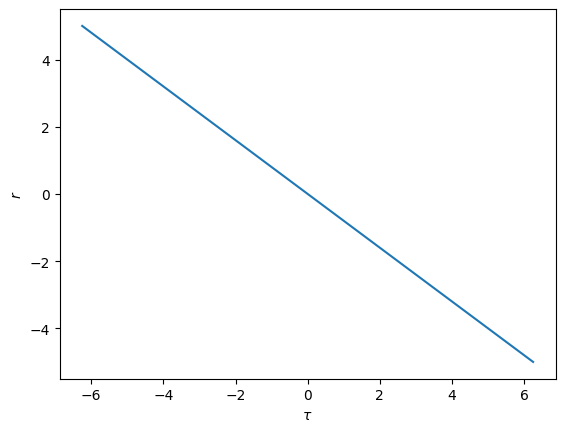

In [19]:
plt.figure()
plt.plot(sol.t, sol.y[1])
plt.xlabel(r'$\tau$')
plt.ylabel('$r$');

In [20]:
def plot_double_polar(y, fig=None):
    if fig == None:
        fig = plt.figure(figsize=(8, 4))
    tmin, tmax = min(y[0]), max(y[0])

    in_pos_plane = y[1] > 0
    in_neg_plane = ~in_pos_plane

    ax = fig.add_subplot(121, projection='polar')
    ax.scatter(y[3][in_pos_plane], y[1][in_pos_plane], c=y[0][in_pos_plane], vmin=tmin, vmax=tmax)
    ax.grid(True)

    ax = fig.add_subplot(122, projection='polar')
    ax.scatter(y[3][in_neg_plane], abs(y[1][in_neg_plane]), c=y[0][in_neg_plane], vmin=tmin, vmax=tmax)
    ax.grid(True)
    ax.set_yticklabels(['-'+lab.get_text() for lab in ax.get_yticklabels()])
    return fig

/var/folders/mq/fpm2c9dj11j3lmfhx1hkhrzc0000gn/T/ipykernel_47706/1515656458.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['-'+lab.get_text() for lab in ax.get_yticklabels()])


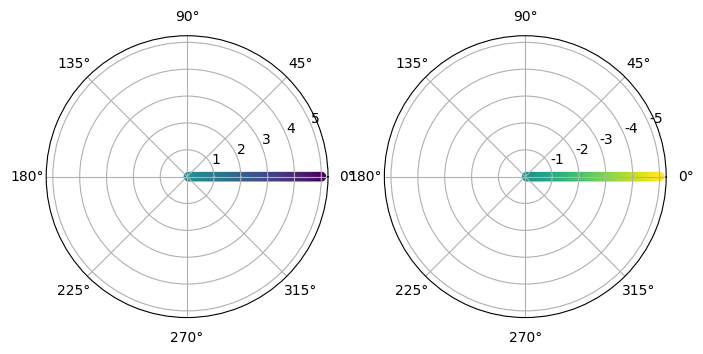

In [21]:
plot_double_polar(sol.y);

Recall our work on the embedding diagram.  Working with cylindrical coordinates, we derived the 2-D surface in flat 3-D space to represent this line element's curvature:

$$
z(r, b) = b\, \text{sinh}^{-1}\left(\frac{r}{b}\right) \\
\rho(z) = b\, \text{cosh}\left(\frac{z}{b}\right)
$$

In [22]:
def get_z(r, b=1):
    return b * np.arcsinh(r/b)

def ρ(z, b=1):
    return b * np.cosh(z/b)

Let's construct a grid for plotting in 3-D.

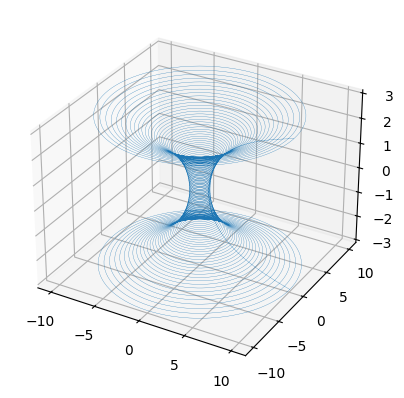

In [23]:
ngrid = 100
zs = np.linspace(-3, 3, ngrid)
ρs = ρ(zs)

ϕs, zs = np.meshgrid(np.linspace(0, 2*np.pi, ngrid), np.linspace(-3, 3, ngrid))
ρs = ρ(zs)

xs = (ρs*np.cos(ϕs)).flatten()
ys = (ρs*np.sin(ϕs)).flatten()
zs = zs.flatten()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.plot(xs, ys, zs, linewidth=0.2)

Now let's plot the trajectory of our infalling particle on the embedding diagram.

In [24]:
def plot_trajectory_on_embedding(y=None, fig=None, ngrid=100, zmax=3):
    if fig is None:
        fig = plt.figure()
    zs = np.linspace(-1*zmax, zmax, ngrid)
    ρs = ρ(zs)

    ϕs, zs = np.meshgrid(np.linspace(0, 2*np.pi, ngrid), zs)
    ρs = ρ(zs)

    xs = (ρs*np.cos(ϕs)).flatten()
    ys = (ρs*np.sin(ϕs)).flatten()
    zs = zs.flatten()

    ax = fig.add_subplot(projection='3d')

    ax.plot(xs, ys, zs, linewidth=0.2)

    if y is not None:
        zs = get_z(sol.y[1])
        ρs = ρ(zs)
        ϕs = sol.y[3]
        xs = ρs*np.cos(ϕs)
        ys = ρs*np.sin(ϕs)
        ax.plot(xs, ys, zs, linewidth=1, c='r')
    return fig

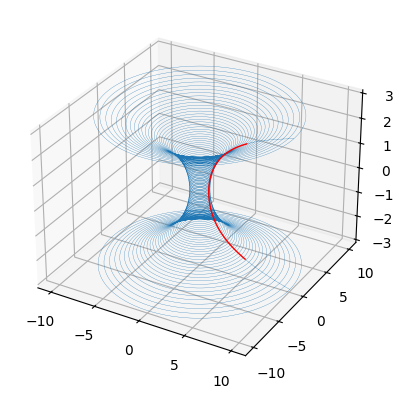

In [25]:
plot_trajectory_on_embedding(sol.y);

Orbit?

In [26]:
R = 5
U = .05

Tmax = 50
T = np.linspace(0, Tmax, 100)

xₒ = [0, R, np.pi/2, 0]

uₒⁱ = [0, 0, U]
uₒ = construct_four_velocity(uₒⁱ)
uₒ

[-1.00124921972504*sqrt(0.00249376558603491*r**2 + 1), 0, 0, 0.05]

In [27]:
uₒ = eval_four_vector_field(construct_four_velocity(uₒⁱ), xₒ)

init_state = xₒ + uₒ

sol = solve_ivp(F, [T[0], T[-1]], init_state, t_eval=T)
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  5.051e-01 ...  4.949e+01  5.000e+01]
        y: [[ 0.000e+00 -5.212e-01 ... -5.108e+01 -5.160e+01]
            [ 5.000e+00  5.002e+00 ...  1.345e+01  1.357e+01]
            ...
            [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            [ 5.000e-02  4.997e-02 ...  7.151e-03  7.026e-03]]
      sol: None
 t_events: None
 y_events: None
     nfev: 50
     njev: 0
      nlu: 0

In [28]:
sol.y[1]

array([ 5.        ,  5.00159398,  5.00637303,  5.01432853,  5.02544617,
        5.03970845,  5.05709206,  5.07756144,  5.10107792,  5.12760011,
        5.15708386,  5.18948227,  5.2247457 ,  5.26282175,  5.30365527,
        5.34718837,  5.39336039,  5.44210795,  5.49336489,  5.54706233,
        5.6031286 ,  5.66148933,  5.72207661,  5.78488328,  5.84984122,
        5.91686834,  5.98588521,  6.05681497,  6.1295834 ,  6.20411889,
        6.28035243,  6.35821764,  6.43765074,  6.51859059,  6.60097863,
        6.68475894,  6.7698782 ,  6.8562857 ,  6.94393336,  7.03277571,
        7.12276987,  7.21387562,  7.3060553 ,  7.39927391,  7.49349904,
        7.5887009 ,  7.6848523 ,  7.7819287 ,  7.87990813,  7.97877123,
        8.07847236,  8.17896328,  8.2802184 ,  8.38221276,  8.48492199,
        8.58832238,  8.69239079,  8.79710471,  8.90244225,  9.00838213,
        9.11490369,  9.22198688,  9.32961225,  9.43776099,  9.54641489,
        9.65555637,  9.76516843,  9.87523472,  9.9857395 , 10.09

/var/folders/mq/fpm2c9dj11j3lmfhx1hkhrzc0000gn/T/ipykernel_47706/1515656458.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['-'+lab.get_text() for lab in ax.get_yticklabels()])


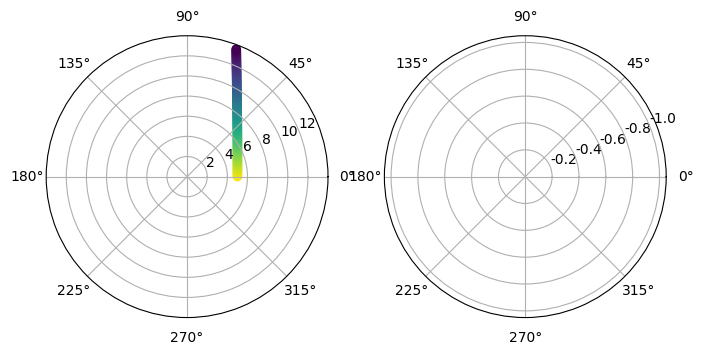

In [29]:
plot_double_polar(sol.y);

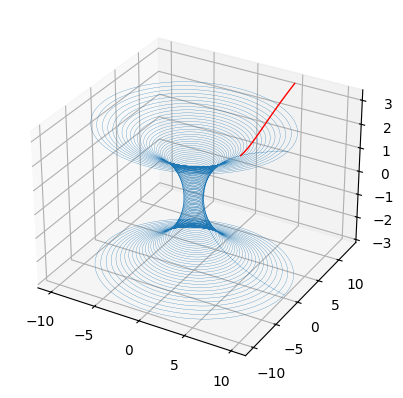

In [30]:
plot_trajectory_on_embedding(sol.y);

In [31]:
ngrid = 100
Tmax = 20
T = np.linspace(0, Tmax, 100)

xₒ = [0, 8, np.pi/2, -np.pi/4]

uₒⁱ = [-.8, 0, .01]
uₒ = eval_four_vector_field(construct_four_velocity(uₒⁱ), xₒ)
sol = solve_ivp(F, [T[0], T[-1]], xₒ+uₒ, t_eval=T)

/var/folders/mq/fpm2c9dj11j3lmfhx1hkhrzc0000gn/T/ipykernel_47706/1515656458.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['-'+lab.get_text() for lab in ax.get_yticklabels()])


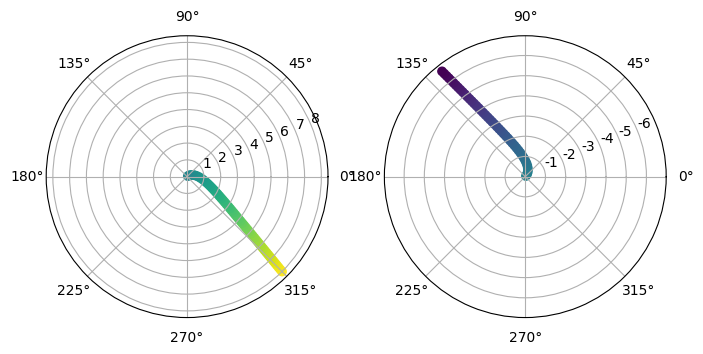

In [32]:
plot_double_polar(sol.y);

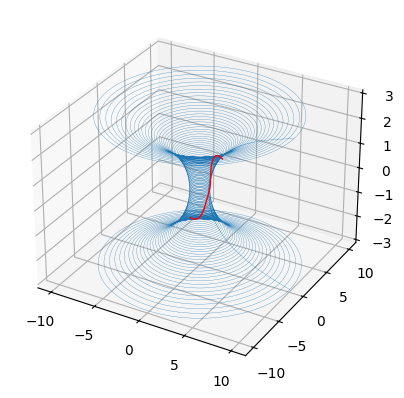

In [33]:
plot_trajectory_on_embedding(sol.y);

In [34]:
ngrid = 100
Tmax = 200
T = np.linspace(0, Tmax, 100)

xₒ = [0, 100, np.pi/2, 0]

uₒⁱ = [-.8, 0, .0001]
uₒ = eval_four_vector_field(construct_four_velocity(uₒⁱ), xₒ)
sol = solve_ivp(F, [T[0], T[-1]], xₒ+uₒ, t_eval=T)
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  2.020e+00 ...  1.980e+02  2.000e+02]
        y: [[ 0.000e+00 -2.587e+00 ... -2.535e+02 -2.561e+02]
            [ 1.000e+02  9.838e+01 ...  5.657e+01  5.818e+01]
            ...
            [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            [ 1.000e-04  1.033e-04 ...  3.112e-04  2.942e-04]]
      sol: None
 t_events: None
 y_events: None
     nfev: 176
     njev: 0
      nlu: 0

/var/folders/mq/fpm2c9dj11j3lmfhx1hkhrzc0000gn/T/ipykernel_47706/1515656458.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['-'+lab.get_text() for lab in ax.get_yticklabels()])


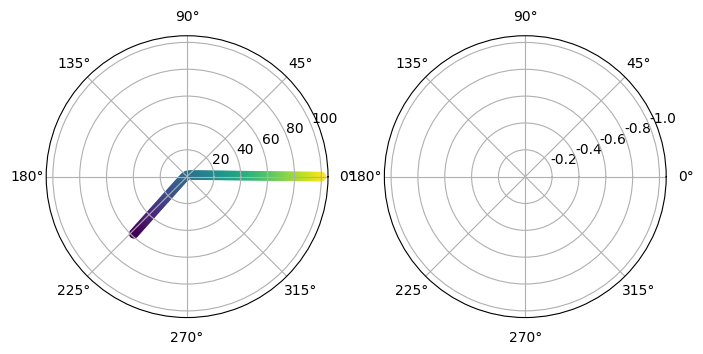

In [35]:
plot_double_polar(sol.y);

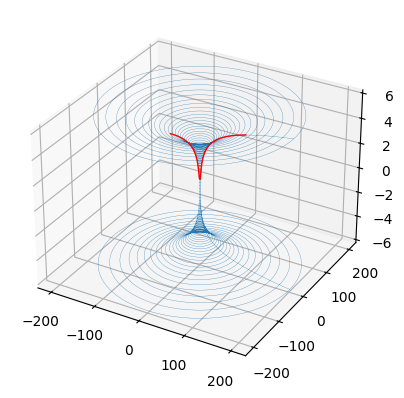

In [36]:
plot_trajectory_on_embedding(sol.y, zmax=6);

In [37]:
min(sol.y[1])

np.float64(0.86130083456516)